In [148]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mglearn
import graphviz
import time
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [48]:
##get to know dataset

In [106]:
df = pd.read_csv("Ecolicounts.csv")
df.head()

,PId,Village/Farm/Marketno,Studysite,Status,Sampletype,Sample1or2,Season,Uniqueid,TBXcount,StatusTBX,...,NDM1,pH,Conductivity,Temp,GISND,GISNM,GISED,GISEM,GISlat,GISlong
0,TR001,1,Rural household,High exposure,Compound soil,1,Winter,11211TR001,0,Negative,...,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TR001,1,Rural household,High exposure,Drinking water,1,Winter,11311TR001,0,Negative,...,0.00,7.4,173.0,25.4,NaN,NaN,NaN,NaN,NaN,NaN
2,TR001,1,Rural household,High exposure,Waste water,1,Winter,11411TR001,220000,Positive,...,174999.38,7.7,202.0,22.7,NaN,NaN,NaN,NaN,NaN,NaN
3,TR001,1,Rural household,High exposure,Downstream river water,1,Winter,11611TR001,217,Positive,...,0.00,7.6,262.0,22.7,24.0,5.384,90.0,6.273,24.08973,90.10455
4,TR001,1,Rural household,High exposure,Poultry pens,1,Winter,11811TR001,22000000,Positive,...,101832.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.keys()
#variables to drop for nonwater samples: PId, Village/Farm/Marketno, Sample1or2, Uniqueid, TBX count, Status TBX, ESBL count, KPC count, pH, conductivity, temp, GIDND, GISNM, GISED, GISEM, GISlat, GISlong
#variables to drop for water samples ('Downstream river water', 'Downstream pond water', 'Poultry drinking water', 'Waste water', 'Waste water-2': everything but pH, conductivtiy, temp


Index(['PId', 'Village/Farm/Marketno', 'Studysite', 'Status', 'Sampletype',
       'Sample1or2', 'Season', 'Uniqueid', 'TBXcount', 'StatusTBX',
       'ESBLcount', 'StatusESBL', 'KPCcount', 'StatusK', 'CTXM', 'NDM1', 'pH',
       'Conductivity', 'Temp', 'GISND', 'GISNM', 'GISED', 'GISEM', 'GISlat',
       'GISlong'],
      dtype='object')

In [16]:
df['Village/Farm/Marketno'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 21, 22, 23, 24,
       35, 36, 37, 38, 39, 40])

In [18]:
df['Studysite'].unique()

array(['Rural household', 'Poultry farm', 'Live bird market'],
      dtype=object)

In [20]:
df['Status'].unique()

array(['High exposure', 'Low exposure'], dtype=object)

In [22]:
df['Sampletype'].unique()

array(['Compound soil', 'Drinking water', 'Waste water',
       'Downstream river water', 'Poultry pens', 'Poultry caecal sample',
       'Human faeces', 'Poultry caecal sample-2', 'Downstream pond water',
       'Animal manure', 'Human faeces-2', 'Poultry drinking water',
       'Human faeces-3', 'Pond sediment', 'River sediment',
       'Poultry Poultry caecal sample-2', 'Poultry Poultry caecal sample',
       'Solid waste', 'Waste water-2', 'Solid waste-2', 'Poultry pens-2'],
      dtype=object)

In [160]:
df.isna().sum()

PId                         0
Village/Farm/Marketno       0
Studysite                   0
Status                      0
Sampletype                  0
Sample1or2                  0
Season                      0
Uniqueid                    0
TBXcount                    0
StatusTBX                   0
ESBLcount                   0
StatusESBL                  0
KPCcount                    0
StatusK                     0
CTXM                        0
NDM1                        0
pH                        819
Conductivity              825
Temp                      846
GISND                    1168
GISNM                    1169
GISED                    1169
GISEM                    1169
GISlat                   1169
GISlong                  1169
dtype: int64

In [108]:
#subset water samples to deal with NAs

water_data = df[df['Sampletype'].isin(['Downstream river water',
                                       'Downstream pond water', 
                                       'Poultry drinking water', 
                                       'Waste water', 
                                       'Waste water-2'])].copy()

water_data.head()


,PId,Village/Farm/Marketno,Studysite,Status,Sampletype,Sample1or2,Season,Uniqueid,TBXcount,StatusTBX,...,NDM1,pH,Conductivity,Temp,GISND,GISNM,GISED,GISEM,GISlat,GISlong
2,TR001,1,Rural household,High exposure,Waste water,1,Winter,11411TR001,220000,Positive,...,174999.38,7.7,202.0,22.7,NaN,NaN,NaN,NaN,NaN,NaN
3,TR001,1,Rural household,High exposure,Downstream river water,1,Winter,11611TR001,217,Positive,...,0.00,7.6,262.0,22.7,24.0,5.384,90.0,6.273,24.08973,90.10455
10,TR002,2,Rural household,High exposure,Waste water,1,Winter,11411TR002,1400000,Positive,...,0.00,9.2,1154.0,24.5,NaN,NaN,NaN,NaN,NaN,NaN
11,TR002,2,Rural household,High exposure,Downstream pond water,1,Winter,11511TR002,98,Positive,...,0.00,8.7,111.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
12,TR002,2,Rural household,High exposure,Downstream river water,1,Winter,11611TR002,5000,Positive,...,0.00,7.9,247.0,24.0,24.0,5.745,90.0,5.907,24.09575,90.09845


In [100]:
water_data.columns

Index(['PId', 'Village/Farm/Marketno', 'Studysite', 'Status', 'Sampletype',
       'Sample1or2', 'Season', 'Uniqueid', 'TBXcount', 'StatusTBX',
       'ESBLcount', 'StatusESBL', 'KPCcount', 'StatusK', 'CTXM', 'NDM1', 'pH',
       'Conductivity', 'Temp', 'GISND', 'GISNM', 'GISED', 'GISEM', 'GISlat',
       'GISlong'],
      dtype='object')

In [112]:
#drop unnecessary columns
water_data = water_data.drop(['PId', 'Village/Farm/Marketno',
       'Sample1or2','Uniqueid', 'TBXcount', 'StatusTBX',
       'ESBLcount','KPCcount','GISND', 'GISNM', 'GISED', 'GISEM', 'GISlat',
       'GISlong'], axis = 1)
water_data.columns

Index(['Studysite', 'Status', 'Sampletype', 'Season', 'StatusESBL', 'StatusK',
       'CTXM', 'NDM1', 'pH', 'Conductivity', 'Temp'],
      dtype='object')

In [122]:
#look at where the remaining NAs are
water_data.isna().sum()

Studysite        0
Status           0
Sampletype       0
Season           0
StatusESBL       0
StatusK          0
CTXM             0
NDM1             0
pH               8
Conductivity    13
Temp            33
dtype: int64

In [124]:
#drop for now since theres only ~50
water_data = water_data.dropna()

In [128]:
#get dummies for categorical variables
water_data = pd.get_dummies(water_data, columns=['Studysite', 'Status', 'Sampletype', 'Season', 'StatusESBL', 'StatusK', ])

water_data.head()

,CTXM,NDM1,pH,Conductivity,Temp,Studysite_Live bird market,Studysite_Poultry farm,Studysite_Rural household,Status_High exposure,Status_Low exposure,...,Sampletype_Downstream river water,Sampletype_Poultry drinking water,Sampletype_Waste water,Sampletype_Waste water-2,Season_Summer,Season_Winter,StatusESBL_Negative,StatusESBL_Positive,StatusK_Negative,StatusK_Positive
2,0.00,174999.38,7.7,202.0,22.7,0,0,1,1,0,...,0,0,1,0,0,1,0,1,1,0
3,0.00,0.00,7.6,262.0,22.7,0,0,1,1,0,...,1,0,0,0,0,1,0,1,1,0
10,211928.52,0.00,9.2,1154.0,24.5,0,0,1,1,0,...,0,0,1,0,0,1,0,1,1,0
11,0.00,0.00,8.7,111.0,23.0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,1,0
12,0.00,0.00,7.9,247.0,24.0,0,0,1,1,0,...,1,0,0,0,0,1,0,1,1,0


In [130]:
water_data.columns

Index(['CTXM', 'NDM1', 'pH', 'Conductivity', 'Temp',
       'Studysite_Live bird market', 'Studysite_Poultry farm',
       'Studysite_Rural household', 'Status_High exposure',
       'Status_Low exposure', 'Sampletype_Downstream pond water',
       'Sampletype_Downstream river water',
       'Sampletype_Poultry drinking water', 'Sampletype_Waste water',
       'Sampletype_Waste water-2', 'Season_Summer', 'Season_Winter',
       'StatusESBL_Negative', 'StatusESBL_Positive', 'StatusK_Negative',
       'StatusK_Positive'],
      dtype='object')

In [132]:
#drop out redundant dummy columns
water_data = water_data.drop(['Status_Low exposure', 'Season_Winter', 'StatusESBL_Negative', 'StatusK_Negative'], axis = 1)
water_data.columns

Index(['CTXM', 'NDM1', 'pH', 'Conductivity', 'Temp',
       'Studysite_Live bird market', 'Studysite_Poultry farm',
       'Studysite_Rural household', 'Status_High exposure',
       'Sampletype_Downstream pond water', 'Sampletype_Downstream river water',
       'Sampletype_Poultry drinking water', 'Sampletype_Waste water',
       'Sampletype_Waste water-2', 'Season_Summer', 'StatusESBL_Positive',
       'StatusK_Positive'],
      dtype='object')

In [136]:
#split data 80/20
X_train, X_test, y_train, y_test = train_test_split(water_data.drop('StatusESBL_Positive', axis = 1), water_data['StatusESBL_Positive'],
                                                    random_state=0)

#fit random forest classifier
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [138]:
#get accuracy
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.978
Accuracy on test set: 0.747


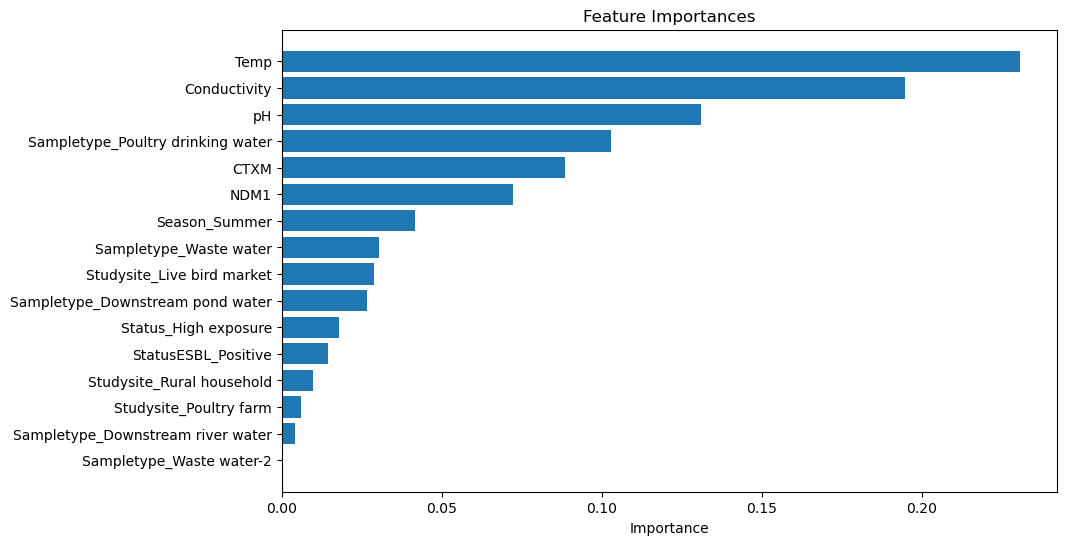

In [144]:
#plot feature importance graph
importances = forest.feature_importances_

feature_names = water_data.columns  

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


In [172]:
#do a grid search iterating over 5 values for n_estimators and max depth

#initialize parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

#get best parameters and accuracy scores
print("Grid-Search with accuracy")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid_search.best_score_))
print("Test set accuracy: {:.3f}".format(grid_search.score(X_test, y_test)))


Grid-Search with accuracy
Best parameters: {'max_depth': 5, 'n_estimators': 100}
Best cross-validation score (accuracy)): 0.784
Test set accuracy: 0.791


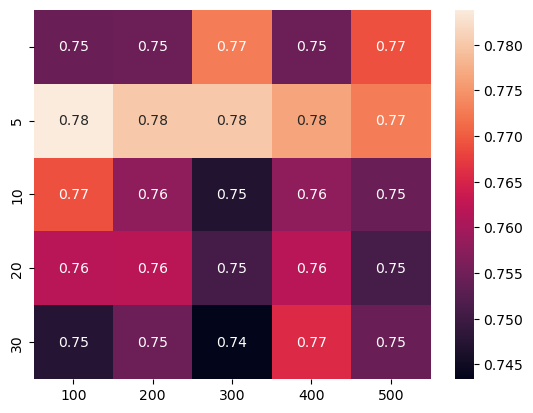

In [173]:
#make a heatmap of the grid search results
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results['mean_test_score']).reshape(5, 5)
sns.heatmap(scores, annot=True, xticklabels = param_grid['n_estimators'], yticklabels = param_grid['max_depth'])
plt.show()